<a href="https://colab.research.google.com/github/konan-91/OcularClassification/blob/master/notebooks/1_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generating Topoplots from Blinks

Our first step is to transform the dataset of ocular & non-ocular EEG data into spectograms (image files) that we can use to train the model.

In [1]:
!pip install mne -q
!pip install pymatreader -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 38.0 MB/s eta 0:00:00


In [2]:
import mne
import pymatreader
import matplotlib.pyplot as plt
import numpy as np
import os

##Loading the data

Note: if you are running this notebook yourself, please ensure the zipped osf dataset is present at the root of your working directory. In Colab, this is /content.

In [3]:
!unzip -q /content/osfstorage-archive.zip
!rm /content/osfstorage-archive.zip

In [4]:
def load_data(folderpath, data):
    for filename in os.listdir(folderpath):
        if filename.endswith(".set"):
            filepath = os.path.join(folderpath, filename)
            epochs = mne.read_epochs_eeglab(filepath) # The dataset we use comes pre-epoched
            data.append(epochs)

In [5]:
mne.set_log_level('ERROR')
path = "/content/osfstorage-archive"
participantsData = [] # List of participants, who are objects containing (many) epochs

for study in os.listdir(path):
    study_path = os.path.join(path, study)
    if os.path.isdir(study_path):
        load_data(study_path, participantsData)

/usr/local/lib/python3.11/dist-packages/pymatreader/utils.py:168: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(
/usr/local/lib/python3.11/dist-packages/pymatreader/utils.py:168: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(
/usr/local/lib/python3.11/dist-packages/pymatreader/utils.py:168: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(
/usr/local/lib/python3.11/dist-packages/pymatreader/utils.py:168: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(
/usr/local/lib/python3.11/dist-packages/pymatreader/utils.py:168: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mi

###Understanding the Dataset

Participants were asked to rest, blink, and make horizontal and vertical eye movements. As such, the dataset contains labelled and timestamped data of when each event occured. Labelled data is ideal for training classification models, as we can teach it to accurately disciminate between each event.

The OSF training dataset is split into 5 studies. Each study contains EEGLAB objects which represent each participant in the study. Each object is a collection of epochs, containing rest events, blinks, or saccades. Each epoch may contain anywhere from 6-20 events of *only* one of the prior listed event types. In order to maximise the amount of training data, we need to split the data so that each individual event has it's own epoch (ex. each blink is its own epoch, rather than an epoch containing 6+ blinks).

In [6]:
blinks_data = [participant['4'] for participant in participantsData]
blinkTriggerData = [participant.get_data(picks='eye-blink') for participant in blinks_data]

Below is a graph of an blink epoch containing 7 individual blinks, alongside a graph of the trigger channel. Data will be re-epoched at the start of each trigger, ending at the beginning of the next (or when the epoch ends).

<EpochsEEGLAB | 1 events (all good), 0 – 7.995 s (baseline off), ~1.1 MiB, data loaded,
 '4/blink/blink/blink/blink/blink/blink/blink': 1>


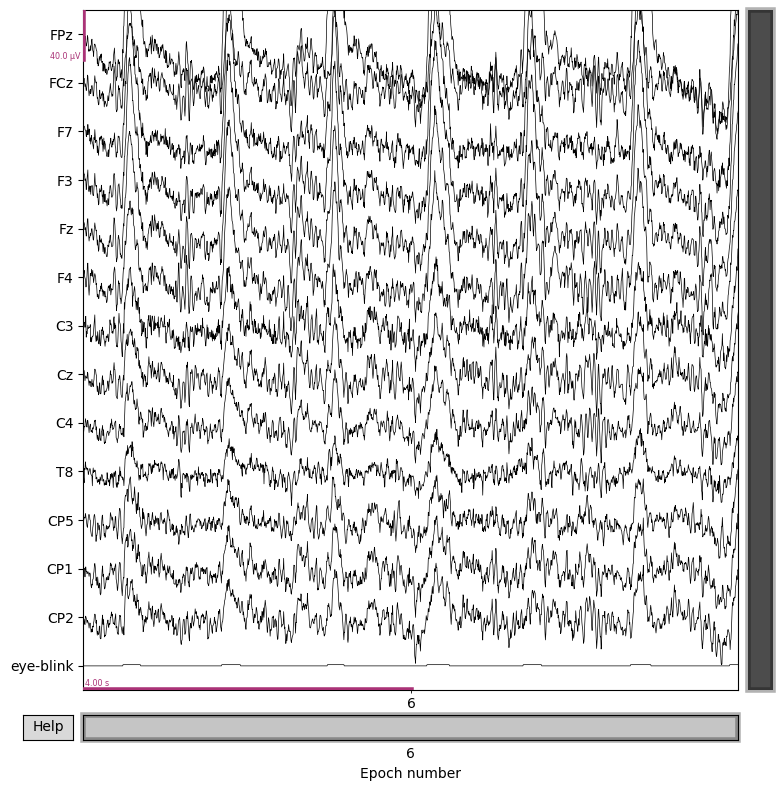

In [7]:
print(blinks_data[0][0])
blinks_data[0][0].plot(picks=['eye-blink', 'C3', 'C4', 'FPz', 'FCz', 'F7', 'F3', 'Fz', 'F4', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2']);

Function which takes a list of epochs, and divides each epoch based on a trigger channel. (Although it assumes we're using a MNE object, not EEGLabs). Also making folder for all the converted things to go in.

In [8]:
print(type(blinks_data))
print(type(blinks_data[0]))

os.makedirs("converted_epochs", exist_ok=True)

<class 'list'>
<class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>


In [9]:
def eeglabs_to_mne(eeglabs_epochs):
    epoch_no = 0

    for epoch in eeglabs_epochs:
        # Initialize event dictionary and event list
        event_dict = {}
        event_list = []

        # Extract unique event names from EEGLAB
        for i, event_desc in enumerate(epoch.events[:, -1]):
            # Convert event label to a string (ensure compatibility)
            event_label = str(epoch.event_id.get(event_desc, event_desc))

            # Assign a unique integer ID if not already assigned
            if event_label not in event_dict:
                event_dict[event_label] = len(event_dict) + 1  # Ensure event_id values are integers

            event_list.append([epoch.events[i, 0], 0, event_dict[event_label]])

        # Convert to numpy array
        event_array = np.array(event_list, dtype=int)  # Ensure integer type for MNE compatibility

        # Update the EEGLAB epochs object with new events and event_id
        epoch.events = event_array
        epoch.event_id = event_dict  # Ensure keys are strings and values are integers

        # Save the converted epochs
        save_path = os.path.join("converted_epochs", f"{epoch_no}-epo.fif")
        epoch.save(save_path, overwrite=True)
        epoch_no += 1

In [10]:
eeglabs_to_mne(blinks_data)

In [11]:
converted_epochs = []
for filename in os.listdir("converted_epochs"):
    if filename.endswith(".fif"):
        filepath = os.path.join("converted_epochs", filename)
        converted_epochs.append(mne.read_epochs(filepath))

In [12]:
print(type(converted_epochs[0]))
print(f"objects: {len(converted_epochs)}")

total_epochs = 0
for epoch in converted_epochs:
    total_epochs += len(epoch)
print(f"total epochs: {total_epochs}")

<class 'mne.epochs.EpochsFIF'>
objects: 5
total epochs: 53


Next: Use MNE object and re-epoch it based on the trigger channel!

In [13]:
from typing import List

def split_epochs_by_blinks(epochs_list: List[mne.Epochs]) -> List[mne.Epochs]:
    split_epochs_list = []

    for epochs in epochs_list:
        # Get the 'eye-blink' channel index
        blink_ch_idx = epochs.ch_names.index('eye-blink')

        # Get sampling frequency
        sfreq = epochs.info['sfreq']

        # Get all epoch data
        data = epochs.get_data()

        # New data list to store single-blink epochs
        new_data = []
        new_events = []

        # Time window for new epochs (in samples)
        tmin_samples = int(-0.2 * sfreq)  # 200ms before
        tmax_samples = int(0.5 * sfreq)   # 500ms after
        window_length = tmax_samples - tmin_samples

        # Keep track of used time points
        used_times = set()

        for i in range(len(epochs)):
            # Get the trigger channel data for this epoch
            trigger_data = data[i, blink_ch_idx, :]

            # Find all timestamps where blinks start (trigger value changes from 0 to 1)
            blink_starts = np.where(np.diff(trigger_data) > 0)[0]

            for blink_start in blink_starts:
                # Calculate absolute time point
                abs_time = epochs.events[i, 0] + blink_start

                # If this timestamp is already used, increment until we find an unused one
                while abs_time in used_times:
                    abs_time += 1

                used_times.add(abs_time)

                # Calculate window indices
                start_idx = blink_start + tmin_samples
                end_idx = blink_start + tmax_samples

                # Check if window is within epoch bounds
                if start_idx >= 0 and end_idx < data.shape[2]:
                    # Extract data window around blink
                    blink_data = data[i, :, start_idx:end_idx]
                    new_data.append(blink_data)

                    # Create an event for this blink
                    new_events.append([abs_time, 0, epochs.events[i, 2]])

        if not new_data:
            print(f"No valid blink events found in epoch set")
            continue

        # Convert lists to arrays
        new_data = np.array(new_data)
        new_events = np.array(new_events)

        # Create new Epochs object
        new_epochs = mne.EpochsArray(
            new_data,
            epochs.info.copy(),
            new_events,
            tmin=-0.2,
            event_id=epochs.event_id,
            verbose=False
        )

        split_epochs_list.append(new_epochs)

    return split_epochs_list

In [14]:
split_epochs = split_epochs_by_blinks(converted_epochs)

# Printing etc
print(type(split_epochs[0]))
print(f"objects: {len(split_epochs)}")
total_epochs = 0
for epoch in split_epochs:
    total_epochs += len(epoch)
print(f"total epochs: {total_epochs}")

<class 'mne.epochs.EpochsArray'>
objects: 5
total epochs: 319


Plot of all epochs from participant 1 before splitting...

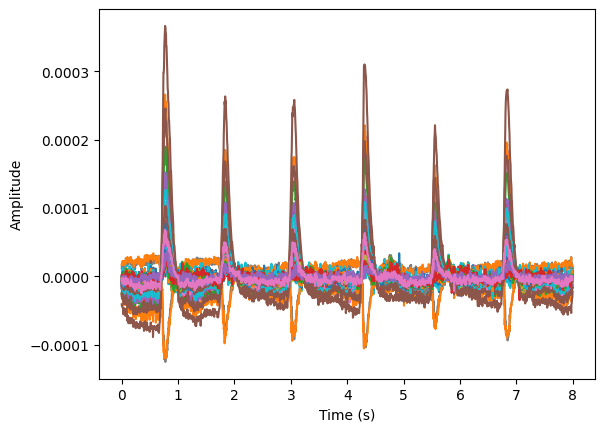

In [15]:
exclude_channels = [
    "target_X", "target_Z", "target_S", "HEOG_lpf", "VEOG_lpf", "REOG_lpf",
    "block", "eye-l", "eye-r", "eye-d", "eye-u", "eye-blink", "eye-fix",
    "eye-art", "label", "artifactclasses"]

epoch_data = converted_epochs[0].get_data()[0]  # First epoch (shape: n_channels x n_times)
times = converted_epochs[0].times

include_indices = [i for i, ch in enumerate(converted_epochs[0].ch_names) if ch not in exclude_channels]
filtered_data = epoch_data[include_indices, :]  # Exclude channels

plt.plot(times, filtered_data.T)  # Transpose for correct shape
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

...And after splitting!

67
140


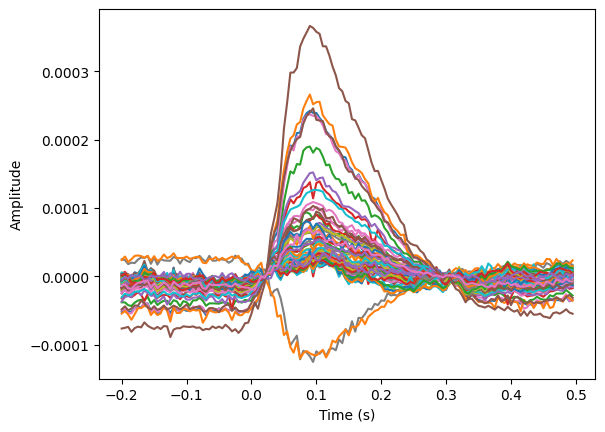

In [16]:
exclude_channels = [
    "target_X", "target_Z", "target_S", "HEOG_lpf", "VEOG_lpf", "REOG_lpf",
    "block", "eye-l", "eye-r", "eye-d", "eye-u", "eye-blink", "eye-fix",
    "eye-art", "label", "artifactclasses"]

epoch_data = split_epochs[0].get_data()[0]  # First epoch (shape: n_channels x n_times)
times = split_epochs[0].times

include_indices = [i for i, ch in enumerate(split_epochs[0].ch_names) if ch not in exclude_channels]
filtered_data = epoch_data[include_indices, :]  # Exclude channels

print(len(filtered_data))
print(len(times))

plt.plot(times, filtered_data.T)  # Transpose for correct shape
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Making topoplots!

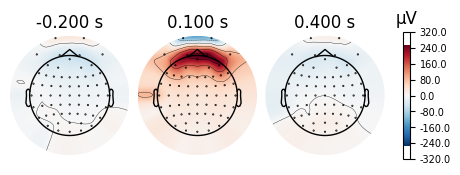

In [17]:
# Drop the unwanted channels
tmp_plot = split_epochs
for epoch in tmp_plot:
    # Check which channels exist in the epoch and exclude them
    channels_to_drop = [ch for ch in exclude_channels if ch in epoch.info['ch_names']]
    if channels_to_drop:
        epoch.drop_channels(channels_to_drop)

# Compute the evoked response (ERP)
evoked = tmp_plot[0][0].average() # The extra [0] is just an MNE quirk

# Plot topographic maps at specific time points
evoked.plot_topomap(times=[-0.2, 0.1, 0.4], ch_type="eeg");

How to genereat

Notes:

Image maps may work as an alternative to Topoplots.

https://mne.tools/1.8/generated/mne.find_events.html